# Predicting the Outcome of a Professional Tennis Match with K-nn Classification

## Introduction

People are always expecting something that would be unlikely to happen in reality. In tennis, who could perform better if Roger Federer plays 1000 games with Rafael Nadal? Or, the possible results for Novak Djokovic playing against Maria Sharapova?

In this project, we will use the dataset atp2017-2019.csv, which includes all ATP tour results for top 500 tennis players to predict the possibility of winning when two professional tennis players play against eachother.

With this dataset, we attempt to answer **two questions:**
    - Is it possible to create a model that reliably predicts the outcome of a match before it has even begun?
    - What factors would make good predictors for such a model?
    
In order to create this model, we sought out predictors within our dataset that would have been information available before the match. This meant that any data collected during the match (aces, points won at halftime, etc) were unusable. In the end, we ended up with three possible predictors: **age, height and rank points** (a numerical measurement of a tennis player's skill; higher the better)


### Introduction - Research into Predictors

Our initial step was to conduct some research into the relation of our three factors into professional tennis. 
We found the following:


- Jeff Sackmann (2017) argues that height does indeed have an effect on the outcome of a match; taller players generally serve better, but players who are too tall tend to perform worse as they are less nimble.


- Chris Chase (2018) provides information on the tennis ranking point system; it is reset every year, and measures performance by point totals earned in the past year. Although we expect ranking points to be a good predictor (it is a direct measurement of player performance) Chase argues that the rankings do not necessarily predict the best player; only the player who's done the best in the previous year. Regardless, it is still a direct metric for player skill.


- Wells and Chemi (2017) finds that the professional tennis player as a whole is getting older; the average age of the pro is increasing. This suggests that older tennis players perform just as well as younger ones and are able to stay professional, suggesting that age may have little correlation with the outcome of a match.

Our research provides good insight into how these three factors might influence a tennis match. In particular, ranking points and height look promising for now. However, if they are good predictors remains to be seen after our **exploratory data analysis.**


## Methods & Results

In [1]:
# Loading the necessary libraries
library(tidyverse)
library(caret)
library(repr)
install.packages('e1071', dependencies=TRUE)
require(ggplot2)
require(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.2.0     ✔ purrr   0.3.2
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   0.8.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:purrr’:

    lift

Warning message in install.packages("e1071", dependencies = TRUE):
“installation of package ‘e1071’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Loading required package: reshape2

Attaching package: ‘reshape2’

The following object is masked from ‘package:tidyr’:

    smiths



First, we load the dataframe and assign it to a variable.

In [2]:
# Reading the csv data from the url
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn")
head(tennis)

Warning message:
“Missing column names filled in: 'X1' [1]”Parsed with column specification:
cols(
  .default = col_double(),
  tourney_id = col_character(),
  tourney_name = col_character(),
  surface = col_character(),
  tourney_level = col_character(),
  winner_seed = col_character(),
  winner_entry = col_character(),
  winner_name = col_character(),
  winner_hand = col_character(),
  winner_ioc = col_character(),
  loser_seed = col_character(),
  loser_entry = col_character(),
  loser_name = col_character(),
  loser_hand = col_character(),
  loser_ioc = col_character(),
  score = col_character(),
  round = col_character()
)
See spec(...) for full column specifications.


X1,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,2019-M020,Brisbane,Hard,32,A,20181231,300,105453,2,⋯,54,34,20,14,10,15,9,3590,16,1977
1,2019-M020,Brisbane,Hard,32,A,20181231,299,106421,4,⋯,52,36,7,10,10,13,16,1977,239,200
2,2019-M020,Brisbane,Hard,32,A,20181231,298,105453,2,⋯,27,15,6,8,1,5,9,3590,40,1050
3,2019-M020,Brisbane,Hard,32,A,20181231,297,104542,NA,⋯,60,38,9,11,4,6,239,200,31,1298
4,2019-M020,Brisbane,Hard,32,A,20181231,296,106421,4,⋯,56,46,19,15,2,4,16,1977,18,1855
5,2019-M020,Brisbane,Hard,32,A,20181231,295,104871,NA,⋯,54,40,18,15,6,9,40,1050,185,275


After loading the dataset, we select the relevant columns that we want for the model (age, height and rank points for both the winner and the loser). Next, we remove any invalid rows that contain NA values.

We use the nrow() function to get the number of valid observations (this gives us a hint to whether our sample size will be sufficient) after which we begin the cleaning process by splitting the data into two equal halves.

**Challenges of Cleaning**

There are two main obstacles we seek to eliminate by wrangling the dataset into tidy format.
- Our class variable (who won the match) is in the column names
- We want to change the class names in a way to avoid upsampling; that is, we want to create a class variable with "win" and "loss" and have each value equally common

In [3]:

tennis_selected <- select(tennis, winner_rank_points, loser_rank_points, winner_age, loser_age, winner_ht, loser_ht) %>%
                   na.omit()

num_obs <- nrow(tennis_selected)
num_obs

tennis_selected_1 <- head(tennis_selected, n = 1454)
tennis_selected_2 <- tail(tennis_selected, n = 1454)


[1] 2908

We have 2908 valid observations! That seems to be plenty enough for the algorithm.

Next, we remove the class variable from the column names. We replace "winner" and "loser" with either "Player 1" or "Player 2" We want the observations to distinctly refer to each individual player, but we don't want the column names to say anything about who won or lost.

The new column for the class variable we create, "result" has two outcomes; either Player 1 wins, or Player 2 does.

We split the dataframe in two in the last step in order to have half the observations be "Player 1 Wins" and the other half be "Player 2 Wins". This guarantees we have enough of each value in our class variable.

In [4]:

player_1_won_colnames <-c("Player_1_RP", "Player_2_RP", "Player_1_Age", "Player_2_Age", "Player_1_HT", "Player_2_HT")
player_2_won_colnames <-c("Player_2_RP", "Player_1_RP", "Player_2_Age", "Player_1_Age", "Player_2_HT", "Player_1_HT")

colnames(tennis_selected_1) <- player_1_won_colnames
colnames(tennis_selected_2) <- player_2_won_colnames

As we are comparing the two players directly, their individual stats do not matter. Rather, it is their difference we need to use as predictors in our model. In order to keep things consistent, we always subtract Player 2's stats from Player 1.

Finally, we combine the two datasets to produce the final dataset we will be using.

In [5]:

tennis_player_1_won <- tennis_selected_1 %>%
                       mutate(rp_diff = Player_1_RP - Player_2_RP, age_diff = Player_1_Age - Player_2_Age, ht_diff = Player_1_HT - Player_2_HT) %>%
                       select(rp_diff, age_diff, ht_diff) %>%
                       mutate(result = "Player 1 Wins!")

tennis_player_2_won <- tennis_selected_2 %>%
                       mutate(rp_diff = Player_1_RP - Player_2_RP, age_diff = Player_1_Age - Player_2_Age, ht_diff = Player_1_HT - Player_2_HT) %>%
                       select(rp_diff, age_diff, ht_diff) %>%
                       mutate(result = "Player 2 Wins!")

tennis_cleaned <- rbind(tennis_player_1_won, tennis_player_2_won)
head(tennis_cleaned)

rp_diff,age_diff,ht_diff,result
<dbl>,<dbl>,<dbl>,<chr>
2540,-2.877481,-10,Player 1 Wins!
1755,1.377139,-10,Player 1 Wins!
-75,8.202601,-5,Player 1 Wins!
752,-1.919233,5,Player 1 Wins!
2780,2.633812,-2,Player 1 Wins!
-6,4.687201,7,Player 1 Wins!


Now our dataset is in the format we want! But we still haven't completed the crucial step of finding out whether **our predictors are actually related to the class variable outcomes.** Our next step answers that question.

# EXPLORATORY DATA ANALYSIS

In this step we attempt to check whether our candidate predictors (age, height, rank points) are actually good indicators for which player wins.

Our first stage is a numerical summary; we find the mean and median differences of these statistics in all situations where Player 1 won.



In [6]:
tennis_player_1_statistics <- tennis_player_1_won %>%
                                summarise(mean_age_diff = mean(age_diff),
                                         mean_ht_diff = mean(ht_diff),
                                         mean_rp_diff = mean(rp_diff),
                                         median_age_diff = median(age_diff),
                                         median_ht_diff = median(ht_diff),
                                         median_rp_diff = median(rp_diff)) 


tennis_player_1_statistics

mean_age_diff,mean_ht_diff,mean_rp_diff,median_age_diff,median_ht_diff,median_rp_diff
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-0.1249733,0.8775791,958.3659,-0.02464066,0,365.5


**Above: Fig 1.0**



What do we find from this?

**In all games where player 1 won...**
- On average, player 1 had 958 more rank points than Player 2. This suggests a strong correlation between rank points and winning. The median of 365.5 says the same.
- On average, player 1 was slightly younger than player 2. This indicates the possibility of a relation.
- On average, player 1 was 0.87cm taller than player 2. The median is actually zero; this suggests that height has no difference in winning. (0.87cm is a very negligible amount when most players are above 150cm tall.)


In summary, rank points is almost certain to be a good indicator. Age has a possibility. Height is in doubt.


Although numerical summaries are useful, it is always good to have a visualization in which we can actually look at the distribution of our class variable across the entire spectrum.

Below, we use a side-by-side histogram where we compare the count of each class variable in order to further check whether our predictors are useful or not.

Using result as id variables
Using result as id variables
Using result as id variables


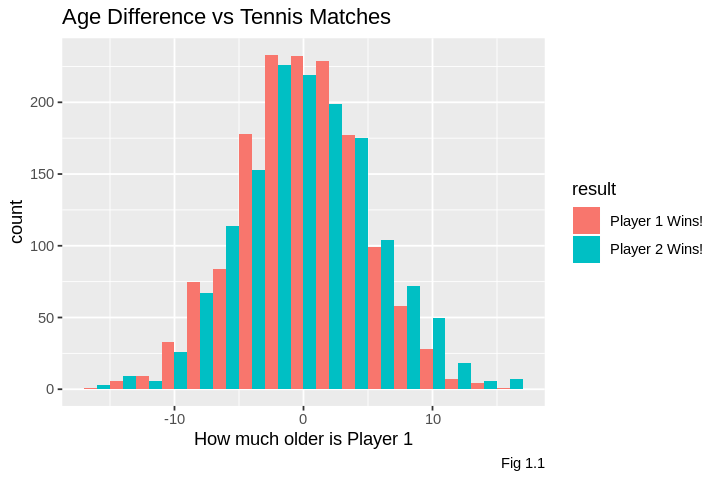

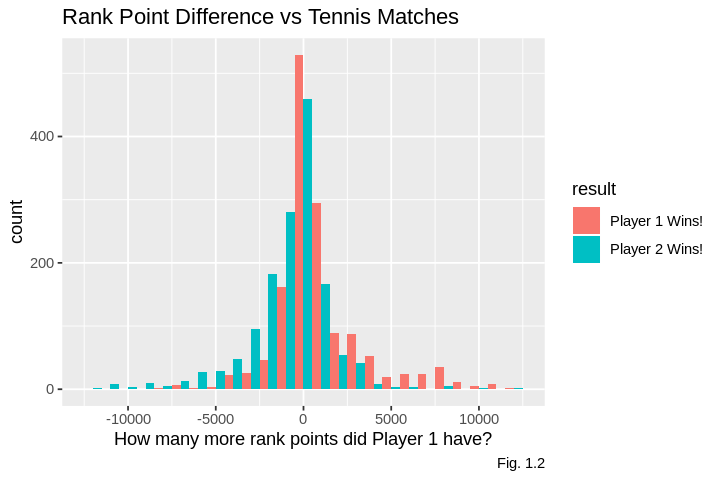

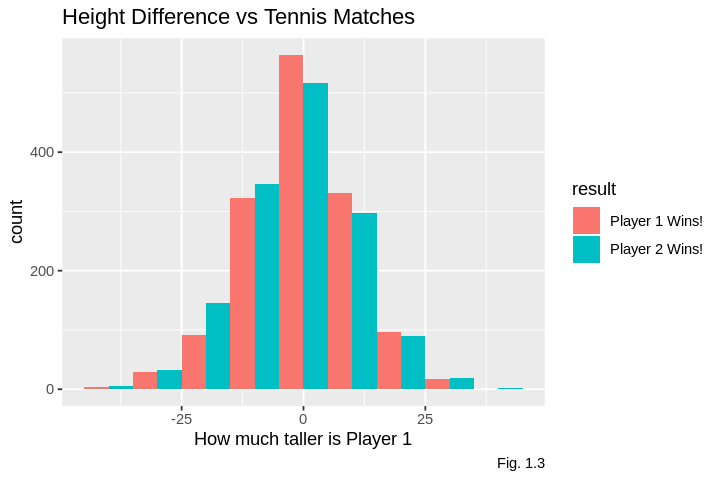

In [7]:
# EXPLORATORY DATA ANALYSIS
options(repr.plot.height = 4, repr.plot.width = 6)


tennis_selected_age <- tennis_cleaned %>%
                   select(age_diff, result)
age_diff_analysis <- ggplot(melt(tennis_selected_age), aes(value, fill = result)) +
                 geom_histogram(position = "dodge", binwidth = 2) +
                 labs(x = "How much older is Player 1", caption = "Fig 1.1") + 
                 ggtitle("Age Difference vs Tennis Matches") 



tennis_selected_rp <- tennis_cleaned %>%
                   select(rp_diff, result)
rp_diff_analysis <- ggplot(melt(tennis_selected_rp), aes(value, fill = result)) +
                 geom_histogram(position = "dodge", binwidth = 1000) +
                 labs(x = "How many more rank points did Player 1 have?", caption = "Fig. 1.2") + 
                 ggtitle("Rank Point Difference vs Tennis Matches") 



tennis_selected_ht <- tennis_cleaned %>%
                   select(ht_diff, result)
ht_diff_analysis <- ggplot(melt(tennis_selected_ht), aes(value, fill = result)) +
                 geom_histogram(position = "dodge", binwidth = 10) +
                 labs(x = "How much taller is Player 1", caption = "Fig. 1.3") + 
                 ggtitle("Height Difference vs Tennis Matches") 


age_diff_analysis
rp_diff_analysis
ht_diff_analysis

Let us look at each histogram and analyze the results.


**Age Difference vs Tennis Matches** (Fig 1.1)

- In the middle where the ages are the same, there is almost an equal likelihood of either player winning.

- When player 1 is younger than player 2, player 1 seems to have a consistent, slightly higher likelihood of winning.

- When player 1 is older than player 2, player 1 seems to have a consistent, small likelihood of losing.

**Ranking Point Difference vs Tennis Matches** (Fig 1.2)
- Whichever player has more ranking points, they have a high, consistent likelihood of winning.


- There is a bit of an anomaly in the middle: when we have near equal ranking points, player 1 has a higher likelihood of winning. This is a bit odd - but we brushed it off as a bias in the sample because the correlation in the left/right extremes were so pronounced.

**Height Difference vs Tennis Matches** (Fig 1.3)

The distribution of winning/losing over height is nearly equal across the board. This suggests that height is not a good predictor.

### Conclusions From the Exploratory Data Analysis

We find that ranking points has a strong relationship with our class variable, whereas age has a weaker but still apparent relationship. Height, however, is likely to have no relationship.

Therefore, in our model, we will use **age and ranking points** as predictors.

## Building our Classification Model

First, we create a training and testing set with a 75%-25% distribution. As the createDataPartition uses random splitting, we set a seed to guarantee our data analysis is reproducible.

In [8]:
# Setting the seed
set.seed(1)
set_rows <- tennis_cleaned %>% 
    select(result) %>% 
    unlist() %>% 
    createDataPartition(p = 0.75, list = FALSE)
training_set <- tennis_cleaned %>% slice(set_rows)
test_set <- tennis_cleaned %>% slice(-set_rows)

We recognize that scaling is necessary in this dataset - after all, ranking points is in a scale of thousands whereas age will obviously be in the tens at most. As the classification algorithm involves a calculation of euclidean distance, we scale our dataset in order to make sure both age and ranking points are weighed equally.

We create the scale transformer according to the training set, then we scale both the training and testing sets.

In [9]:
set.seed(1)
scale_transformer <- training_set %>% preProcess(method = c("center", "scale"))

training_set <- predict(scale_transformer, training_set)
test_set <- predict(scale_transformer, test_set)

After this, we split the training and the test sets into the predictor variables and the classification variables.

For our X-sets, we select our predictors, rank and age difference. For our y-sets, we select our class variable - result.

In [10]:
set.seed(1)
X_train <- training_set %>% 
    select(rp_diff, age_diff) %>% 
    data.frame()


Y_train <- training_set %>% 
    select(result) %>% 
    unlist()


X_test <- test_set %>%
          select(rp_diff, age_diff) %>%
          data.frame()


Y_test <- test_set %>% 
    select(result) %>% 
    unlist() %>%
    as.factor()

Now, we need to create our model to find the most accurate k. Get a list of k values from 1 to 200 in increments of 5 to use for knn classification. Setup the train control for 10-fold cross validation and then train the knn classification model using the above objects.

In [11]:
set.seed(1)
ks = data.frame(k = seq(from = 1, to = 200, by = 5))
train_control <- trainControl(method="cv", number = 10)
model_knn <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = ks, trControl = train_control)
model_knn

k-Nearest Neighbors 

2182 samples
   2 predictor
   2 classes: 'Player 1 Wins!', 'Player 2 Wins!' 

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 1964, 1964, 1964, 1963, 1964, 1963, ... 
Resampling results across tuning parameters:

  k    Accuracy   Kappa    
    1  0.5724310  0.1448605
    6  0.6241967  0.2484194
   11  0.6471116  0.2942296
   16  0.6521637  0.3042846
   21  0.6540028  0.3079925
   26  0.6494093  0.2987957
   31  0.6526371  0.3052384
   36  0.6521700  0.3043004
   41  0.6475787  0.2951101
   46  0.6489548  0.2978694
   51  0.6521658  0.3042859
   56  0.6526245  0.3052027
   61  0.6572096  0.3143770
   66  0.6544636  0.3088828
   71  0.6553726  0.3107014
   76  0.6558397  0.3116398
   81  0.6530895  0.3061357
   86  0.6544615  0.3088853
   91  0.6521721  0.3043008
   96  0.6517113  0.3033700
  101  0.6517113  0.3033633
  106  0.6535461  0.3070511
  111  0.6558355  0.3116259
  116  0.6562922  0.3125481
  121  0.6553789  0.3107096
  

Get the accuracies of the model for each k, then plot it onto a graph to find the best k value. Our model data says that the best value for k was 151.

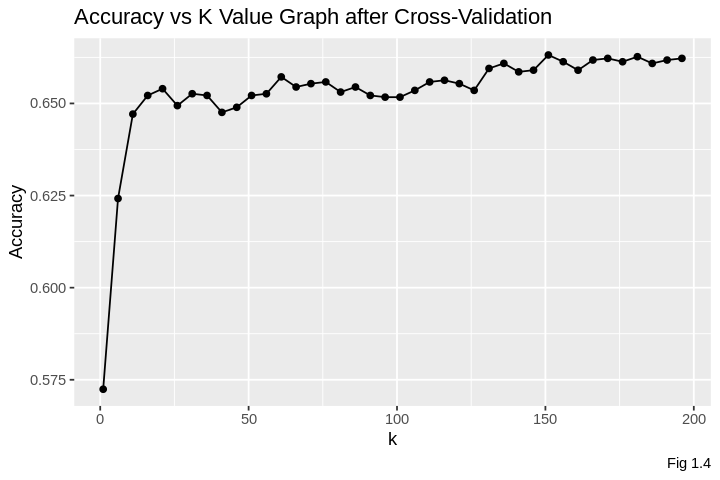

In [16]:
accuracies <- model_knn$results 

accuracy_vs_k <- ggplot(accuracies, aes(x = k, y = Accuracy)) + geom_point() + geom_line() + labs(caption = "Fig 1.4") + ggtitle("Accuracy vs K Value Graph after Cross-Validation")
accuracy_vs_k

From the graph (figure 1.4), we also find that 151 was the best k value for our model. We use this value to create the final classfication model.

In [13]:
set.seed(1)
k <- data.frame(k = 151)

final_knn_model <- train(x = X_train, y = Y_train, method = "knn", tuneGrid = k)
final_knn_model

k-Nearest Neighbors 

2182 samples
   2 predictor
   2 classes: 'Player 1 Wins!', 'Player 2 Wins!' 

No pre-processing
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2182, 2182, 2182, 2182, 2182, 2182, ... 
Resampling results:

  Accuracy   Kappa    
  0.6506794  0.3013266

Tuning parameter 'k' was held constant at a value of 151

Next, we use the model above to predict our test set, and then find the quality of our model using the confusion matrix.

In [14]:
set.seed(1)
Y_test_pred <- predict(object = final_knn_model, X_test)

model_quality <- confusionMatrix(data = Y_test_pred, reference = Y_test)
model_quality
model_quality$overall[1]

Confusion Matrix and Statistics

                Reference
Prediction       Player 1 Wins! Player 2 Wins!
  Player 1 Wins!            267            158
  Player 2 Wins!             96            205
                                          
               Accuracy : 0.6501          
                 95% CI : (0.6142, 0.6848)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 2.436e-16       
                                          
                  Kappa : 0.3003          
                                          
 Mcnemar's Test P-Value : 0.0001295       
                                          
            Sensitivity : 0.7355          
            Specificity : 0.5647          
         Pos Pred Value : 0.6282          
         Neg Pred Value : 0.6811          
             Prevalence : 0.5000          
         Detection Rate : 0.3678          
   Detection Prevalence : 0.5854          
      Balanced Accuracy : 0.6501          
                          

Accuracy 
0.6501377

From the confusion matrix, we find that our model predicts 65% of the outcomes in the test set correctly. We will discuss whether this is a good accuracy or not.

Below is a final visualization of our model (Figure 1.5) - the highlighted areas represent which class the model would output if you put in a new observation at that point. Recall that rp_diff and age_diff are calculated via (player 1 - player 2).

From our visualization we clearly see that the model is highly dependent on rp_diff, and slightly dependent on age_diff. (The older player 1 is, the more likely he/she is to lose.)

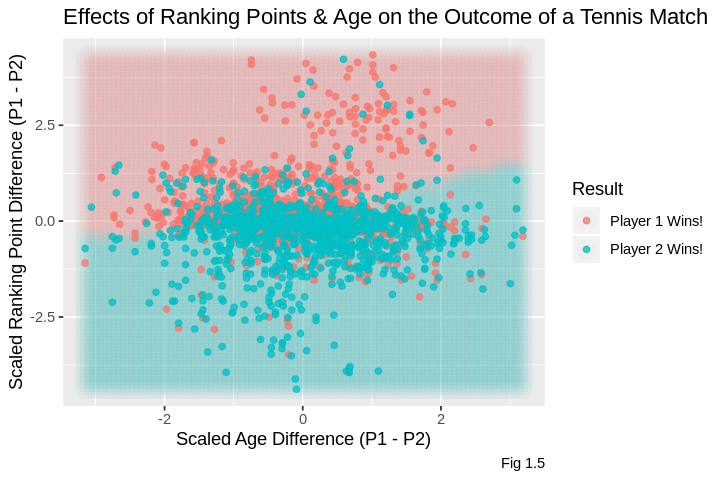

In [17]:
rp_grid <- seq(min(training_set$rp_diff), max(training_set$rp_diff), length.out = 100)
age_grid <- seq(min(training_set$age_diff), max(training_set$age_diff), length.out = 100)
pcgrid <- expand.grid(rp_diff=rp_grid, age_diff=age_grid)
knnPredGrid <- predict(final_knn_model, newdata=pcgrid)
prediction_table <- bind_cols(pcgrid, data.frame(result=knnPredGrid))
#create the basic plt
rare_plot <-
ggplot() +
geom_point(data = prediction_table, mapping=aes(x = age_diff, y = rp_diff, color = result), alpha=0.02, size=5.)+
geom_point(data = training_set, mapping=aes(x = age_diff, y = rp_diff, color = result), alpha=0.75) +
labs(color = "Result", x = "Scaled Age Difference (P1 - P2)", y = "Scaled Ranking Point Difference (P1 - P2)", caption = "Fig 1.5") +
ggtitle("Effects of Ranking Points & Age on the Outcome of a Tennis Match")
rare_plot

# Discussion

**What did we find from this?**

This project showed us that the main factors that could affect the result of the game (not including statistics from during or after the game) is the rank points and to an extent, the age. From the project, we also learnt that it is difficult to predict the winner of a game before the game due to the fact that many of the attributes that could alter the results depend on what happens during the game. In general:

- The player with the higher rank points is more likely to win
- The younger player has a slightly higher chance to win

**Is this what we expected to find?**

While we originally thought our model should have a higher accuracy, upon more research, we discovered that the current accuracy (65%) we have is acceptable, as every model has different accuracies depending on what we are classifying. If we were blindly guessing the outcome of the game, we would have a 50% accuracy, as the two outcomes are equally likely. However, with our model, we get an accuracy that is 15% better than that, which shows that the current accuracy of our model is acceptable.

According to an external source, what consists of a "good accuracy" is highly subjective. (Saitta, 2010) In general, the more outcomes there are and the more external factors involved, the lower the bar for a "good accuracy." A tennis match has countless factors, from weather, style of play, everything about the individual players. From this, we believe our accuracy of 65% is good.

As for our factors, we initially expected height and rank points to be our predictors. According to our referred article, age was suggested to be a non-factor. However, our findings opposed this; from our exploratory data analysis we saw that age does indeed have a slight effect on the outcome of a tennis match.

**What is the impact of these findings?**

This model could be used by sports analysts, managers and players when strategising, as well as in betting to help predict who the result of the game could be. It also makes it easier to see what factors come into play in a match, and could help make the tournaments more fair (ie, people of similar rank points or similar age play each other).

The fact that our findings oppose popular research also raises additional questions and inspires possible, further thorough research into the topic.

**What future questions could this lead to?**

This could lead to questions about any other attributes of players which could affect their performance. It could also lead to questions about the importance of data taken during the match, and how much that could affect the accuracy of the model - for example, what if you create a model using data from the first half of the match instead? What results would that produce?

# References

Sackman, J. (2018, September 1). How Much Does Height Matter in Men's Tennis? Retrieved from http://www.tennisabstract.com/blog/2017/09/04/how-much-does-height-matter-in-mens-tennis/

Saitta, S. (2010, April 11). What is a good classification accuracy in data mining? Retrieved from http://www.dataminingblog.com/what-is-a-good-classification-accuracy-in-data-mining/

Chase, C. (2020, February 2). Why tennis rankings change so frequently but still get it right. Retrieved from https://ftw.usatoday.com/2018/08/atp-wta-tennis-rankings-how-do-they-work-faq-federer-serena-nadal

Wells, N., & Chemi, E. (2017, January 28). This country really is for old men (and women): Professional tennis is older than it's ever been. Retrieved from https://www.cnbc.com/2017/01/28/professional-tennis-is-older-than-its-ever-been.html
